In [561]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [624]:
data = pd.read_csv('/Users/katush/Documents/Otus/ML/L05-LinearReg/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
skip = ['id', 'name', 'host_id', 'host_name', 'last_review']
data.drop(skip, axis=1, inplace=True)

In [625]:
print(data[data['price']==0].shape)
data = data[data['price']!=0]

(11, 11)


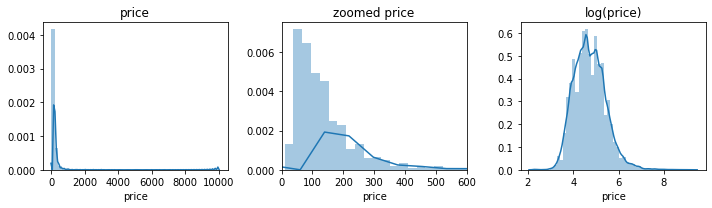

In [626]:
fig = plt.figure(figsize=(10, 3))

plt.subplot(131)
sns.distplot(data['price'])
plt.title('price')

plt.subplot(132)
sns.distplot(data.price, bins=350)
plt.xlim((0, 600))
plt.title('zoomed price')

plt.subplot(133)
sns.distplot(np.log(data['price']))
plt.title('log(price)')

plt.tight_layout()

log_cols = ['price']

In [627]:
cpark = (40.7851, -73.9683)
data['center_distance'] = np.sqrt((data['latitude'] - cpark[0])**2 + (data['longitude'] - cpark[1])**2)
data.drop(['latitude', 'longitude'], axis=1, inplace=True)
features = [i for i in data.columns if i != 'price']

In [628]:
num_cols = [i for i in features if data[i].dtype!='O']
print(num_cols)

['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'center_distance']


,column,nans,zeros
0,minimum_nights,0,0
1,number_of_reviews,0,10051
2,reviews_per_month,10051,0
3,calculated_host_listings_count,0,0
4,availability_365,0,17530
5,center_distance,0,0


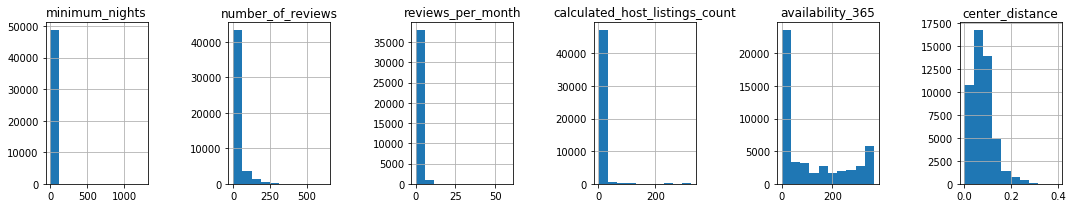

In [629]:
check = []
fig = plt.figure(figsize=(15, 3))
for ix, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), (ix+1))
    data[col].hist()
    plt.title(col)
    check.append([col, data[data[col].isna()].shape[0], data[data[col]==0].shape[0]])
plt.tight_layout()
check = pd.DataFrame(check, columns=['column', 'nans', 'zeros'])
check

In [630]:
print(data[data['number_of_reviews']==0]['reviews_per_month'].unique())
print(data[data['reviews_per_month'].isna()]['number_of_reviews'].unique())
data['reviews_per_month'].fillna(0, inplace=True)

[nan]
[0]


In [631]:
# log_cols = log_cols + ['minimum_nights', 'calculated_host_listings_count', 'center_distance']
log_cols = ['minimum_nights', 'calculated_host_listings_count', 'center_distance']

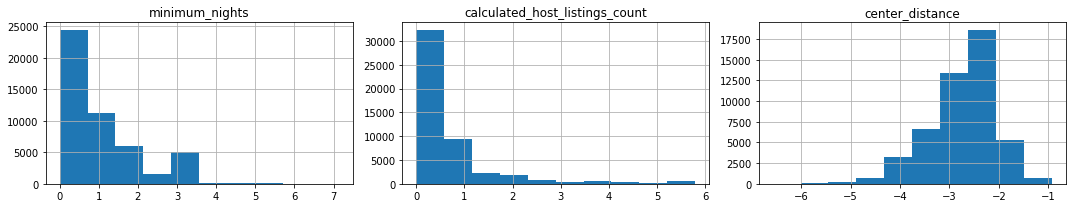

In [632]:
fig = plt.figure(figsize=(15, 3))
for ix, col in enumerate(log_cols):
    plt.subplot(1, len(log_cols), (ix+1))
    np.log(data[col]).hist()
    plt.title(col)
plt.tight_layout()

In [633]:
for i in log_cols:
    data[i] = np.log(data[i])
    print(f'max({i})', data[i].max())

max(minimum_nights) 7.1308988302963465
max(calculated_host_listings_count) 5.7899601708972535
max(center_distance) -0.9299768194168561


In [634]:
obj_cols = [i for i in features if data[i].dtype=='O']
print(obj_cols)

for col in obj_cols:
    names = dict(zip(data[col].unique(), [col+': '+i for i in data[col].unique()]))
    data = data.join(pd.get_dummies(data[col], drop_first=True).rename(columns=names)).drop(col, axis=1)

['neighbourhood_group', 'neighbourhood', 'room_type']


In [635]:
dummy_10_cols = list(names.values())

In [636]:
def corr_feature_detect(data, threshold=0.8):
    
    corrmat = data.drop(['price'], axis=1).corr()

    corrmat = corrmat.abs().unstack().sort_values(ascending=False)

    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1]

    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    correlated_feats = []

    for row in corrmat.values:
        f1, f2, corr_value = row

        if not ((f1 in correlated_feats) | (f2 in correlated_feats)):
            f1_feat_len = corrmat[(corrmat.feature1==f1) | (corrmat.feature2==f1)].shape[0]
            f2_feat_len = corrmat[(corrmat.feature1==f2) | (corrmat.feature2==f2)].shape[0]

            if f1_feat_len >= f2_feat_len:
                correlated_feats.append(f1)
            else:
                correlated_feats.append(f2)
    
    return correlated_feats

data_num_corr_features = corr_feature_detect(data, threshold=0.5)
print(data_num_corr_features)

['neighbourhood_group: Brooklyn', 'center_distance', 'reviews_per_month']


In [608]:
data = data.drop(data_num_corr_features, axis=1)

In [609]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [610]:
y_train.max(), y_test.max(), y_train_log.max(), y_test_log.max()

(10000, 8000, 9.210340371976184, 8.987196820661973)

In [611]:
scaler = MinMaxScaler()
# scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.max().max(), X_test.max().max(), X_train_scaled.max().max(), X_test_scaled.max().max()

(607.0, 629.0, 1.0, 1.0362438220757826)

In [620]:
model = LinearRegression()
model.fit(X_train_scaled, y_train_log)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [621]:
y_preds_log = model.predict(X_test_scaled)
y_preds = np.exp(y_preds_log)

y_preds_log.max(), y_preds.max()

(63532369504.90021, inf)

In [468]:
def dataframe_metrics(y_test,y_pred):
    y_test = np.exp(y_test)
    y_pred = np.exp(y_pred)
    
    
    stats = [
       metrics.mean_absolute_error(y_test, y_pred),
       np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
       metrics.r2_score(y_test, y_pred)
    ]
    return stats
measured_metrics = pd.DataFrame({"error_type":["MAE", "RMSE", "R2", "MAPE"]})
measured_metrics.set_index("error_type")

""
error_type
MAE
RMSE
R2
MAPE


In [619]:
measured_metrics["LinReg1"] = dataframe_metrics(y_test, np.log(y_preds))
measured_metrics

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы